# Face (Eye) Landmarks localization on the FEI Face Database

## Importing the libraries

In [1]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage import io, color, transform
import cv2
import dlib
import random
from PIL import Image
from math import *
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Visualising the data

In [2]:
# Plot the grayscale image with red dots representing the landmarks
def draw_landmarks(image, landmarks):
    if(type(image) == np.ndarray):
        plt.figure(figsize=(5,5))
        plt.imshow(image, cmap = 'gray')
        plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'r')
        plt.show()
    else:
        plt.figure(figsize=(5,5))
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'r')

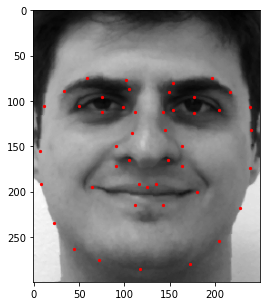

In [3]:
path_images = r"image_path"
path_labels = r"labels_path"

image = io.imread(path_images + "\\1b.jpg")
label = np.loadtxt(path_labels + "\\1b.pts", comments=("version:", "n_points:", "{", "}"))

draw_landmarks(image, label)

## Data Preprocessing

In [4]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

## Dataset Class

In [5]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, image_path, landmarks_path, transform=None):

        self.image_path = image_path
        self.landmarks_path = landmarks_path
        
        self.image_filenames = os.listdir(self.image_path)
        self.image_filenames.sort(key = self.SortKeys)
        
        self.landmarks_filenames = os.listdir(self.landmarks_path)
        self.landmarks_filenames.sort(key = self.SortKeys)
        
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.detector = dlib.get_frontal_face_detector()
        
        for filename, landmark in zip(self.image_filenames, self.landmarks_filenames):
            image = io.imread(self.image_path + "\\" + filename)

            self.crops.append(self.get_crops(image))
            self.landmarks.append(self.read_labels(self.landmarks_path + "\\" + landmark))

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)
    
    def get_crops(self, image):
        detection = self.detector(image, 1)
        crops = {
            'left': detection[0].left(), 
            'top': detection[0].top(), 
            'height': detection[0].bottom() - detection[0].top(), 
            'width': detection[0].right() - detection[0].left()
        }
        return crops
    
    def read_labels(self, filename):
        return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))
    
    def SortKeys(self, s):
        return int(os.path.basename(s)[:-5])

    def __getitem__(self, index):
        image = io.imread(self.image_path + "\\" + self.image_filenames[index])
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(image_path = path_images, landmarks_path = path_labels, transform = Transforms())

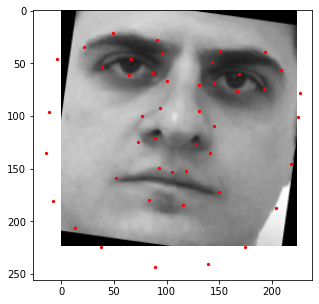

In [6]:
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 224
draw_landmarks(image, landmarks)

## Split the dataset into training and validation sets

In [7]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)

The length of Train set is 351
The length of Valid set is 39


## Testing the shape of the input data

In [8]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 46, 2])


## Defining the Network

In [9]:
class Network(nn.Module):
    # num_classes = 92 because 46 landmarks X 2 coordinates = 92
    def __init__(self,num_classes=92):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        
        # input channel count = 1 for grayscale images
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

## Helper Functions

In [10]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

## Training

In [11]:
torch.autograd.set_detect_anomaly(True)
network = Network()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 20

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images
        landmarks = landmarks.view(landmarks.size(0),-1) 
        
        predictions = network(images)
 
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images
            landmarks = landmarks.view(landmarks.size(0),-1)
        
            predictions = network(images)
            
            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 5/5  Loss: 0.0707 
--------------------------------------------------
Epoch: 1  Train Loss: 0.1906  Valid Loss: 0.0707
--------------------------------------------------

Minimum Validation Loss of 0.0707 at epoch 1/20
Model Saved

Valid Steps: 5/5  Loss: 0.0283 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0316  Valid Loss: 0.0283
--------------------------------------------------

Minimum Validation Loss of 0.0283 at epoch 2/20
Model Saved

Valid Steps: 5/5  Loss: 0.0088 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0070  Valid Loss: 0.0088
--------------------------------------------------

Minimum Validation Loss of 0.0088 at epoch 3/20
Model Saved

Valid Steps: 5/5  Loss: 0.0045 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0048  Valid Loss: 0.0045
--------------------------------------------------

Minimum Validation Loss of 0.0045 at epoch 4/20
Model Saved

Valid Steps: 5/5  Lo